# Anomalous Resource Access with Collaborative Filtering Algorithm Analysis
###### by: Bria Bradley 12/14/20
<p class="lead">This <a href="https://jupyter.org/">Jupyter notebook</a>
shows a basic implementation of k-NN algorithms via Surprise Lib in order to perform
collaborative filtering and anomaly detection on theLastFM-1Billion dataset (LFM), a dataset of 1 billion unique user listening events. </p>

<i>Experimental Setup: Explain how recommendation systems can be used to find anomalous resource access.</i>
<br>
<div class="alert alert-warning">
This project is based on research from <a href="http://www.cp.jku.at/people/schedl/Research/Publications/pdf/schedl_icmr_2016.pdf">
The LFM-1b Dataset for Music Retrieval and Recommendation</a> and <a href=https://www.researchgate.net/profile/Dominik_Kowald/publication/337885099_The_Unfairness_of_Popularity_Bias_in_Music_Recommendation_A_Reproducibility_Study/links/5e709d4e92851c47458fe7f6/The-Unfairness-of-Popularity-Bias-in-Music-Recommendation-A-Reproducibility-Study.pdf>
The Unfairness of Popularity Bias in Music Recommendation: A Reproducibility Study.</a></div>
<br>
<div class="alert alert-block alert-info">
<b>NOTE:</b> Uploading data files is only necessary when running the notebook online. Be sure to use the data set
from the folder labeled <i><b><a href="https://zenodo.org/record/3475975#.XZ7erWbgpPZ">'data'</a><b/><i/>.
</div>

<br>
<p class="lead">The use of the following imports will
allow us to run RecSys algorithms and accuracy metrics, as well as perform Anomaly Detection.</p>

In [142]:
#Scientific and vector computation for python
import numpy as np
#Pandas dataframe helps load a custom dataset
import pandas as pd
#Surprise Library, a Python scikit for building and analyzing recommender systems that deal with explicit rating data, imports
from pandas import DataFrame
from surprise import Reader
from surprise import Dataset
from surprise.model_selection import cross_validate
from surprise import KNNBasic
from surprise import KNNWithMeans
from surprise import KNNWithZScore
from surprise import KNNBaseline
from surprise import BaselineOnly
from surprise.accuracy import rmse
from surprise import accuracy
from surprise.model_selection import train_test_split

#Scikit-Learn Tools
from sklearn.ensemble import IsolationForest
import matplotlib.pyplot as plt
#from pyod.models.knn import KNN
from sklearn.preprocessing import MinMaxScaler

from scipy import stats

import seaborn as sns



## Data Distribution
### Upload LFM file and Display Dataset

<div class="alert alert-block alert-warning">
<i>May take a long time running....comment out data distribution section (ex. .info(), .head(), and.describe() methods) to skip ahead to the algorithm analysis section<i/>.
</div>

In [2]:
user_att = pd.read_csv('D:\LFM\LFM-1b_users_additional.txt', sep='\t')

In [3]:
user_att.head(2)

,user-id,novelty_artist_avg_month,novelty_artist_avg_6months,novelty_artist_avg_year,mainstreaminess_avg_month,mainstreaminess_avg_6months,mainstreaminess_avg_year,mainstreaminess_global,cnt_listeningevents,cnt_distinct_tracks,...,relative_le_per_hour14,relative_le_per_hour15,relative_le_per_hour16,relative_le_per_hour17,relative_le_per_hour18,relative_le_per_hour19,relative_le_per_hour20,relative_le_per_hour21,relative_le_per_hour22,relative_le_per_hour23
0,384,0.27662877856116547,0.044439,0.3094285950064659,0.024655,0.36734262481331825,0.0,0.124903,17198,3601,...,0.0279,0.041,0.0811,0.1506,0.0377,0.0298,0.0132,0.0007,0.0001,0.0151
1,1206,0.43722350196912885,0.109671,0.5137868970632553,0.181991,0.3913043439388275,0.0,0.343855,17967,10990,...,0.0016,0.0115,0.0276,0.0662,0.079,0.0838,0.0995,0.1195,0.0968,0.0839


In [4]:
print('Dataset Column and Type Info:')
user_att.info()
print('Dataset shape: {}'.format(user_att.shape))
#print('-Dataset examples-')
#print(user_att.iloc[::2, :])


Dataset Column and Type Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120322 entries, 0 to 120321
Data columns (total 43 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   user-id                       120322 non-null  int64  
 1   novelty_artist_avg_month      120322 non-null  object 
 2   novelty_artist_avg_6months    120322 non-null  float64
 3   novelty_artist_avg_year       120322 non-null  object 
 4   mainstreaminess_avg_month     120322 non-null  float64
 5   mainstreaminess_avg_6months   120322 non-null  object 
 6   mainstreaminess_avg_year      120322 non-null  float64
 7   mainstreaminess_global        120322 non-null  float64
 8   cnt_listeningevents           120322 non-null  int64  
 9   cnt_distinct_tracks           120322 non-null  int64  
 10  cnt_distinct_artists          120322 non-null  int64  
 11  cnt_listeningevents_per_week  120322 non-null  float64
 12  relative_le_pe

### What's the resource?...Mainstreaminess
According to Wikipedia, the word mainstream is the prevalent current thought that is widespread. It includes all popular culture and media culture, typically disseminated by mass media.

In the The LFM-1b Dataset for Music Retrieval and Recommendation research paper, the <b>mainstreaminess score</b> is the overlap between a user’s listening history
and the combined listening history of all users

The following data shows such scores from an average a span of 1 month, to a year, to finally a computed score for the entire period of the user’s activity on Last.fm

In [5]:
user_att.drop(user_att.columns[[1,2,3,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42]], axis=1, inplace=True)

In [95]:
user_att.columns= ['userID', 'MSAvg_1_month', 'MSAvg_6_months','MSAvg_12_months','MSAvg_entire_user_activity_period']
#mainstreaminess_avg_6months column is oddly marked with an object dtype initially
user_att['MSAvg_6_months'] = pd.to_numeric(user_att.MSAvg_6_months, errors='coerce')
df =user_att
print('The new data frame shape:\t{}'.format(df.shape))
df.head()

The new data frame shape:	(120322, 5)


,userID,MSAvg_1_month,MSAvg_6_months,MSAvg_12_months,MSAvg_entire_user_activity_period
0,384,0.024655,0.367343,0.000000,0.124903
1,1206,0.181991,0.391304,0.000000,0.343855
2,2622,0.052310,0.780064,0.079669,0.245980
3,2732,0.005092,0.886364,0.032614,0.077512
4,3653,0.042821,0.491756,0.077731,0.207567


### Distribution for each column in data frame (df) of user attributes

#### Graphs for Mainstreaminess in 1 month time span

In [7]:
#df.MSAvg_1_month.describe()

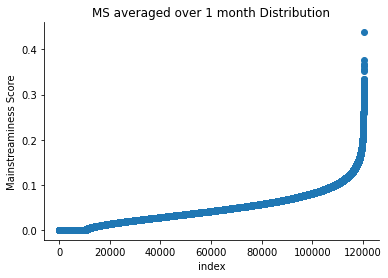

In [8]:
plt.scatter(range(df.shape[0]), np.sort(df['MSAvg_1_month'].values))
plt.xlabel('index')
plt.ylabel('Mainstreaminess Score')
plt.title("MS averaged over 1 month Distribution")
sns.despine()

c:\users\bobo1\appdata\local\programs\python\python37\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


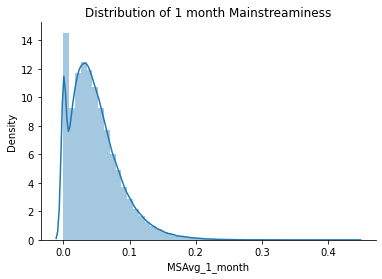

In [9]:
sns.distplot(df['MSAvg_1_month'])
plt.title("Distribution of 1 month Mainstreaminess")
sns.despine()

In [10]:
print("1 Month Skewness: %f" % df['MSAvg_1_month'].skew()) #the distortion or asymmetry in a symmetrical bell curve/normal distribution, in a set of data.
print("1 Month Kurtosis: %f" % df['MSAvg_1_month'].kurt()) #the sharpness of the peak of a frequency-distribution curve.

1 Month Skewness: 1.283249
1 Month Kurtosis: 2.858870


###### If the skewness is between **-0.5 and 0.5**, the data are *fairly symmetrical*. If the skewness is between **-1 and – 0.5 or between 0.5 and 1**, the data are *moderately skewed*. If the skewness is **less than -1 or greater than 1**, the data are *highly skewed*.

###### Data sets with high kurtosis tend to have heavy tails, or outliers. Data sets with low kurtosis tend to have light tails, or lack of outliers.

#### Graphs for Mainstreaminess in 6 months time span

In [11]:
#df.MSAvg_6_months.describe()

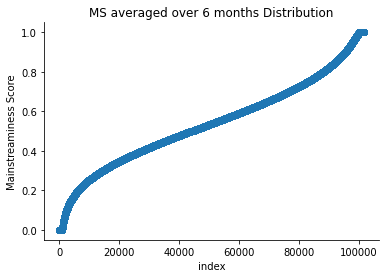

In [12]:
plt.scatter(range(df.shape[0]), np.sort(df['MSAvg_6_months'].values))
plt.xlabel('index')
plt.ylabel('Mainstreaminess Score')
plt.title("MS averaged over 6 months Distribution")
sns.despine()

c:\users\bobo1\appdata\local\programs\python\python37\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


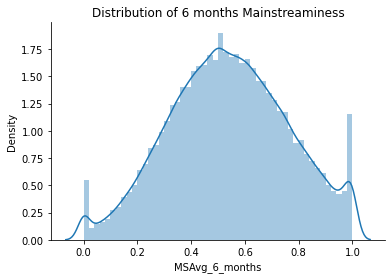

In [13]:
sns.distplot(df['MSAvg_6_months'])
plt.title("Distribution of 6 months Mainstreaminess")
sns.despine()

In [14]:
print("6 Month Skewness: %f" % df['MSAvg_6_months'].skew()) #the distortion or asymmetry in a symmetrical bell curve/normal distribution, in a set of data.
print("6 Month Kurtosis: %f" % df['MSAvg_6_months'].kurt()) #the sharpness of the peak of a frequency-distribution curve.

6 Month Skewness: -0.029006
6 Month Kurtosis: -0.450508


###### If the skewness is between **-0.5 and 0.5**, the data are *fairly symmetrical*. If the skewness is between **-1 and – 0.5 or between 0.5 and 1**, the data are *moderately skewed*. If the skewness is **less than -1 or greater than 1**, the data are *highly skewed*.

###### Data sets with high kurtosis tend to have heavy tails, or outliers. Data sets with low kurtosis tend to have light tails, or lack of outliers.

#### Graphs for Mainstreaminess in 12 months time span

In [15]:
#df.MSAvg_12_months.describe()

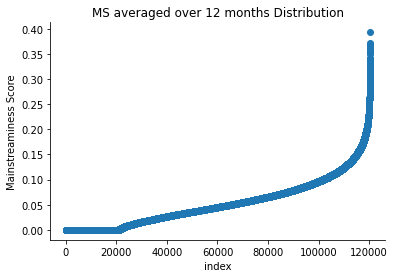

In [16]:
plt.scatter(range(df.shape[0]), np.sort(df['MSAvg_12_months'].values))
plt.xlabel('index')
plt.ylabel('Mainstreaminess Score')
plt.title("MS averaged over 12 months Distribution")
sns.despine()

c:\users\bobo1\appdata\local\programs\python\python37\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


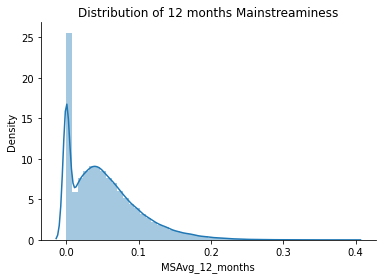

In [17]:
sns.distplot(df['MSAvg_12_months'])
plt.title("Distribution of 12 months Mainstreaminess")
sns.despine()

In [18]:
print("12 Month Skewness: %f" % df['MSAvg_12_months'].skew()) #the distortion or asymmetry in a symmetrical bell curve/normal distribution, in a set of data.
print("12 Month Kurtosis: %f" % df['MSAvg_12_months'].kurt()) #the sharpness of the peak of a frequency-distribution curve.

12 Month Skewness: 1.178281
12 Month Kurtosis: 1.856083


###### If the skewness is between **-0.5 and 0.5**, the data are *fairly symmetrical*. If the skewness is between **-1 and – 0.5 or between 0.5 and 1**, the data are *moderately skewed*. If the skewness is **less than -1 or greater than 1**, the data are *highly skewed*.

###### Data sets with high kurtosis tend to have heavy tails, or outliers. Data sets with low kurtosis tend to have light tails, or lack of outliers.

#### Graphs for Mainstreaminess in total user activity

In [19]:
#df.MSAvg_entire_user_activity_period.describe()

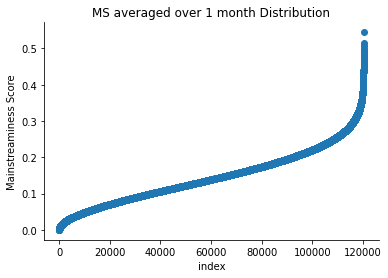

In [20]:
plt.scatter(range(df.shape[0]), np.sort(df['MSAvg_entire_user_activity_period'].values))
plt.xlabel('index')
plt.ylabel('Mainstreaminess Score')
plt.title("MS averaged over Entire User Listening History Mainstreaminess Distribution")
sns.despine()

c:\users\bobo1\appdata\local\programs\python\python37\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


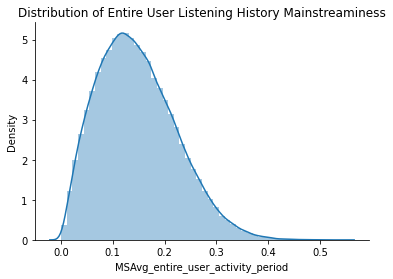

In [21]:
sns.distplot(df['MSAvg_entire_user_activity_period'])
plt.title("Distribution of Entire User Listening History Mainstreaminess")
sns.despine()

In [22]:
print("Total Activity Skewness: %f" % df['MSAvg_entire_user_activity_period'].skew()) #the distortion or asymmetry in a symmetrical bell curve/normal distribution, in a set of data.
print("Total Activity Kurtosis: %f" % df['MSAvg_entire_user_activity_period'].kurt()) #the sharpness of the peak of a frequency-distribution curve.

Total Activity Skewness: 0.536700
Total Activity Kurtosis: 0.020153


###### If the skewness is between **-0.5 and 0.5**, the data are *fairly symmetrical*. If the skewness is between **-1 and – 0.5 or between 0.5 and 1**, the data are *moderately skewed*. If the skewness is **less than -1 or greater than 1**, the data are *highly skewed*.

###### Data sets with high kurtosis tend to have heavy tails, or outliers. Data sets with low kurtosis tend to have light tails, or lack of outliers.

## K-NN Algorithms Analysis

In the previous cells, we saw that mainstreaminess score trend for 1 and 12 month(s) were highly skewed and were more likely to have
outliers. We also witnessed that the mainstreaminess score trend for 6 months and overall user activity were fairly symmetrical
and were less likely to have outliers.

To put the test and train sets into context. The original dataframe, df, has about 1 billion users.
Typically the test and cross_validation sets are 25% of the training set which is 100%.
Here you will see that 003% of our original data set have scores below 50.

In [74]:
#df.groupby('userID')['MSAvg_1_month','MSAvg_6_months','MSAvg_12_months','MSAvg_entire_user_activity_period'].count().reset_index().sort_values('userID', ascending=False)[:10]

In [110]:
#Dimensionality reduction in amount of users with mainstreaminess score counts less than 50
max_ms_score_count = 50

reduce_users = df['userID'].value_counts() < max_ms_score_count
reduce_users = reduce_users[reduce_users].index.tolist()

reduce_1_month = df['MSAvg_1_month'].value_counts() > max_ms_score_count
reduce_1_month  = reduce_1_month [reduce_1_month].index.tolist()

reduce_6_months = df['MSAvg_6_months'].value_counts() > max_ms_score_count
reduce_6_months = reduce_6_months[reduce_6_months].index.tolist()

# split the data into train and test set
poor = df[((df['userID'].isin(reduce_users))  & (df['MSAvg_1_month'].isin(reduce_1_month)))]
better = df[((df['userID'].isin(reduce_users))  & (df['MSAvg_6_months'].isin(reduce_6_months)))]
print('The original data frame shape:\t{}'.format(df.shape))
print('The poor distribution data frame shape:\t{}'.format(poor.shape))
print('The better distribution data frame shape:\t{}'.format(poor.shape))

The original data frame shape:	(120322, 5)
The poor distribution data frame shape:	(10106, 5)
The better distribution data frame shape:	(10106, 5)


To load a dataset from a pandas dataframe, we will use the load_from_df() method,
we will also need a Reader object, and the rating_scale parameter must be specified.
The dataframe must have three columns, corresponding to the user ids, and the mainstreaminess in this order.

In [111]:
#rating scale based on better to poor mainstreaminess score
reader = Reader(rating_scale=(0, 9))

poor_dist = Dataset.load_from_df(poor[['userID', 'MSAvg_1_month','MSAvg_12_months']],reader)
better_dist= Dataset.load_from_df(better[['userID', 'MSAvg_6_months','MSAvg_entire_user_activity_period']],reader)

### Surprise Library Algorithms
<p class="lead">This next section will show results from running suprise library algorithms...

#### BaselineOnly, a basic prediction algorithm:
<ul><li>BasiclineOnly algorithm predicts the baseline estimate for given user
and item/resource.</li></ul>

#### kNN Algorithms:

##### KNNBasic
<ul><li>KNNBasic is a basic collaborative filtering algorithm.</li></ul>

##### KNNWithMeans
<ul><li>KNNWithMeans is basic collaborative filtering algorithm, taking into account the mean ratings of each user.</li></ul>

##### KNNWithZScore
<ul><li>KNNWithZScore is a basic collaborative filtering algorithm, taking into account the z-score normalization of each user.</li></ul>

##### KNNBaseline
<ul><li>KNNBaseline is a basic collaborative filtering algorithm taking into account a baseline rating.</li></ul>

For each algorithm, we use 2 accuracy metrics measures, RMSE and MAE, for the predictions made.
##### Root Mean Squared Derivation
 <ul><li> The standard deviation of the prediction errors</li><ul><li>
 Frequently used measure of the differences between values (sample or population values) predicted
 by a model or an estimator and the values observed.</li><li>The closer the value of RMSE is to zero , the better is the Regression Model.</li></ul></ul>

##### Mean Average Error
 <ul><li> The standard deviation of the prediction errors</li><ul><li>
 Frequently used measure of the differences between values (sample or population values) predicted
 by a model or an estimator and the values observed.</li><li>The closer the value of RMSE is to zero , the better is the Regression Model.</li></ul></ul>

In [122]:
poor_compare = []
# Iterate over all algorithms for cv sets
for algorithm in [BaselineOnly(),KNNBaseline(), KNNBasic(), KNNWithMeans(), KNNWithZScore()]:
    # Perform cross validation
    validation1 = cross_validate(algorithm, poor_dist, measures=['RMSE','MAE'], cv=3, verbose=False)

    # Get results & append algorithm name
    results1 = pd.DataFrame.from_dict(validation1).mean(axis=0)
    results1 = results1.append(pd.Series([str(algorithm).split(' ')[0].split('.')[-1]], index=['Algorithm']))
    poor_compare.append(results1)
p = pd.DataFrame(poor_compare)
p

Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing t

,test_rmse,test_mae,fit_time,test_time,Algorithm
0,0.056767,0.046225,0.030585,0.023606,BaselineOnly
1,0.056771,0.046224,4.887569,0.022578,KNNBaseline
2,0.056768,0.046226,4.272635,0.021282,KNNBasic
3,0.056768,0.046222,4.618242,0.020793,KNNWithMeans
4,0.056769,0.046223,4.521184,0.022318,KNNWithZScore


In [123]:
better_compare = []
# Iterate over all algorithms for cv sets
for algorithm in [BaselineOnly(),KNNBaseline(), KNNBasic(), KNNWithMeans(), KNNWithZScore()]:
    # Perform cross validation
    validation2 = cross_validate(algorithm, better_dist, measures=['RMSE','MAE'], cv=2, verbose=False)

    # Get results & append algorithm name
    results2 = pd.DataFrame.from_dict(validation2).mean(axis=0)
    results2 = results2.append(pd.Series([str(algorithm).split(' ')[0].split('.')[-1]], index=['Algorithm']))
    better_compare.append(results2)

    b = pd.DataFrame(better_compare)
    b

Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.


In [124]:
#surprise_results = pd.DataFrame(poor_compare).set_index('Algorithm').sort_values('test_mae')
surprise_results = pd.DataFrame({'Poor Distribution':poor_compare,'Better Distribution': better_compare})

In [137]:
surprise_results

,Poor Distribution,Better Distribution
0,test_rmse 0.0567665 test_mae 0.04...,test_rmse 0.0512604 test_mae 0.0...
1,test_rmse 0.056771 test_mae 0.0462...,test_rmse 0.0513653 test_mae 0.0406...
2,test_rmse 0.0567681 test_mae 0.0462263 ...,test_rmse 0.051823 test_mae 0.0410964 ...
3,test_rmse 0.0567679 test_mae 0.04...,test_rmse 0.0518383 test_mae 0.04...
4,test_rmse 0.0567686 test_mae 0....,test_rmse 0.0518543 test_mae 0....


ValueError: shape mismatch: objects cannot be broadcast to a single shape

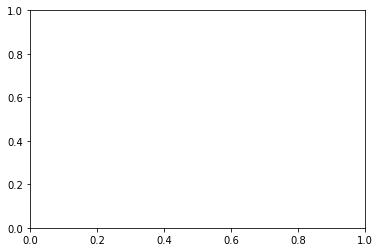

In [162]:
# Bar graph for comparing Accuracy Metrics for each algorithm
x_labels = ["1-month", "6-month", "12-month","Entire User History"]

bar1 = [poor_compare[0] , better_compare[0]]
bar2 = [poor_compare[1] , better_compare[1]]
bar3 = [poor_compare[2] , better_compare[2]]
bar4 = [poor_compare[3] , better_compare[3]]
bar5 = [poor_compare[4] , better_compare[4]]

x1 = np.arange(len(x_labels))
plt.bar(x1+0, bar1, width = 0.15, label ="KNNWithZScore")
plt.bar(x1+1, bar2, width = 0.15, label ="KNNBaseline")
plt.bar(x1+2, bar3, width = 0.15, label ="KNNBasic")
plt.bar(x1+3, bar4, width = 0.15, label ="BaselineOnly")
plt.bar(x1+4, bar5, width = 0.15, label ="KNNWithMeans")

plt.plot.xlabel("User Mainstreaminess Group")
plt.plot.ylabel("Result in Accuracy Metric")
plt.plot.legend(bbox_to_anchor=(1,1), loc="upper left", ncol=1)
plt.plot.xticks(x1 + 0.15, x_labels)
plt.plot.show()

## Anomaly Detection

#### From Scikit-Learn, Isolation Forest Algorithm:

<ul><li>Return the anomaly score of each sample using the IsolationForest algorithm<ul><li>
This algorithm ‘isolates’ observations by randomly selecting a feature
and then randomly selecting a split value between the maximum
and minimum values of the selected feature. </li></ul></li></ul>


In [94]:
isolation_forest = IsolationForest(n_estimators=100)
isolation_forest.fit(df['MSAvg_1_month'].values.reshape(-1, 1))
xx = np.linspace(df['MSAvg_1_month'].min(), df['MSAvg_1_month'].max(), len(df)).reshape(-1,1)
anomaly_score = isolation_forest.decision_function(xx)
outlier = isolation_forest.predict(xx)
plt.figure(figsize=(10,4))
plt.plot(xx, anomaly_score, label='Anomaly Score')
plt.fill_between(xx.T[0], np.min(anomaly_score), np.max(anomaly_score),
                 where=outlier==1, color='b',
                 alpha=.4, label='outlier region')
plt.legend()
plt.ylabel('Anomaly Score')
plt.xlabel('Poor Distribution from 1 month span')
plt.show();

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

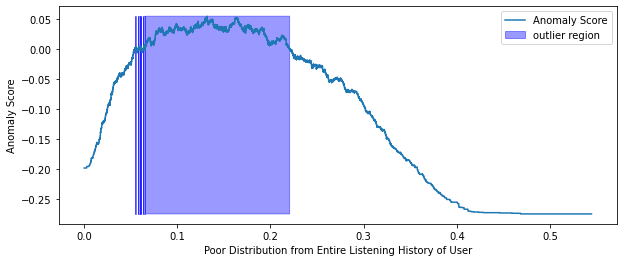

In [160]:
isolation_forest = IsolationForest(n_estimators=100)
isolation_forest.fit(df['MSAvg_entire_user_activity_period'].values.reshape(-1, 1))
xx = np.linspace(df['MSAvg_entire_user_activity_period'].min(), df['MSAvg_entire_user_activity_period'].max(), len(df)).reshape(-1,1)
anomaly_score = isolation_forest.decision_function(xx)
outlier = isolation_forest.predict(xx)
plt.figure(figsize=(10,4))
plt.plot(xx, anomaly_score, label='Anomaly Score')
plt.fill_between(xx.T[0], np.min(anomaly_score), np.max(anomaly_score),
                 where=outlier==1, color='b',
                 alpha=.4, label='outlier region')
plt.legend()
plt.ylabel('Anomaly Score')
plt.xlabel('Poor Distribution from Entire Listening History of User')
plt.show();

In [ ]:
# np.nan_to_num(df['MSAvg_6_months'])
# df.MSAvg_6_months.astype(np.float64, copy=False)
# isolation_forest = IsolationForest()
# isolation_forest.fit(np.nan_to_num(df['MSAvg_6_months']).values.reshape(-1, 1))
# xx = np.linspace(df['MSAvg_6_months'].min(), df['MSAvg_6_months'].max(), len(df)).reshape(-1,1)
# anomaly_score = isolation_forest.decision_function(xx)
# outlier = isolation_forest.predict(xx)
# plt.figure(figsize=(10,4))
# plt.plot(xx, anomaly_score, label='Anomaly Score')
# plt.fill_between(xx.T[0], np.min(anomaly_score), np.max(anomaly_score),
#                  where=outlier==1, color='b',
#                  alpha=.4, label='outlier region')
# plt.legend()
# plt.ylabel('Anomaly Score')
# plt.xlabel('Poor Distribution from 1 month span')
# plt.show();
